In [1]:
# This code splits the given dataset to test-train files.
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scienceplots
#import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import os

# Apply the default theme
#sns.set_theme()
#sns.set_style('white')
#sns.set_context("paper", font_scale = 2)
#plt.style.use(['science','no-latex'])
print('Pandas v', pd.__version__)

Pandas v 1.3.5


# Configurations

In [2]:
# Configurations 
#latex_dir = Path(r"C:\Users\3057550\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal")
#latex_dir = Path(r"C:\Users\kasim\OneDrive - Queen's University Belfast\ECIT\Research\AI_Cybersecurity\Teams Files\Papers\In preparation\NLP for SQLi detection\latex\hybrid_nlp_journal")
latex_dir = Path(r'C:\Users\kasim\Documents\GitHub\hybrid_nlp_journal')
#latex_dir = Path(r'C:\Users\3057550\Documents\GitHub\hybrid_nlp_journal')
#C:\Users\3057550\Documents\GitHub\hybrid_nlp_journal
SAVE_OUTPUTS = False

In [3]:
# Notes about result files:
# 'results_230214_205321.pkl' # classical ML - Dataset: Train Kaggle, Test Kaggle
# 'results_230214_210527.pkl' # classical ML - Dataset: Train Harika, Test Harika
# 'results_230214_211201.pkl' # classical ML- Dataset: Train: Harika.train, Test: Kaggle.test

# 'results_230214_205100.pkl' # bert - Dataset: Train Kaggle, Test Kaggle
# 'results_230309_112627.pkl' # bert- Dataset: Train Harika, Test Harika
# 'results_230214_193603.pkl' # bert- Dataset: Train: Harika.train, Test: Kaggle.test
main_folder = Path('../')


# results_file = main_folder / 'results_230214_205321.pkl' # classical ML
#results_file = main_folder / 'results' / 'results_1680188240.csv' # temp - all
#results_file = main_folder / 'results' / 'results_230331_152406.csv' # temp - all
#results_file = main_folder / 'results' / 'results_230410_165455.csv' # temp - all
#proposed_method_results_file = main_folder / 'results' / 'proposed_method_results.csv'
# results_file = main_folder / 'results' / 'results_230525_153416.csv' # temp - all
results_file = main_folder / 'results' / 'results_230531_combined.csv' # 
#proposed_method_results_file = main_folder / 'results' / 'proposed_method_results_230525.csv' #proposed_method_results_230530_130524
proposed_method_results_file = main_folder / 'results' / 'proposed_method_results_230530_130524_PAC_smallUL8h128a2.csv'
#results_file_bert = main_folder / 'results_230214_205100.pkl' # bert
print(results_file.is_file())
print(proposed_method_results_file.is_file())
#print(results_file_bert.is_file())

True
True


In [4]:
methods={}

methods['classic_ml'] = ['naive_bayes', 'xgboost', 'svm',
                         'XGBoost', 'MultinomialNB', 'SVM_RBF', 'MLPClassifier', 'KNeighborsClassifier', 'NearestCentroid', 
                         'RadiusNeighborsClassifier', 'SVC-GC', 'NuSVC', 'LinearSVC', 'DecisionTreeClassifier', 
                         'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreesClassifier', 'RidgeClassifier', 
                         'SGDClassifier', 'Perceptron', 'LogisticRegression', 'PassiveAggressiveClassifier', 
                         'OneVsRestClassifier', 'OneVsOneClassifier']
methods['ensemble'] = ['ensemble_1', 'ensemble_2',
       'ensemble_3', 'ensemble_4', 'proposed']
methods['transformer'] = ['bert_en_uncased_L-12_H-768_A-12',
       'bert_en_cased_L-12_H-768_A-12',
       'small_bert/bert_en_uncased_L-2_H-128_A-2',
       'small_bert/bert_en_uncased_L-4_H-512_A-8',
       'small_bert/bert_en_uncased_L-8_H-128_A-2',
       'small_bert/bert_en_uncased_L-12_H-768_A-12',
       'bert_multi_cased_L-12_H-768_A-12', 'albert_en_base', 'electra_base',
       'electra_small']
method_categories = [method_cat for method_cat in methods]

# Load and Setup Data

In [5]:
# Rename Columns and Index properly (for latex tables and figures)
def rename_table_labels(df_bad_labeled):
    column_mapper = {
        "accuracy": "Accuracy", 
        "precision": "Precision",
        "recall":"Recall",
        "f1_score":"F1",
        "tn":"TN",
        "tp":"TP",
        "fn":"FN",
        "fp":"FP",
        "train_size":"Train Size",
        "test_size":"Test Size",
        "dataset":"Dataset",
        "train_time":"Training Time (ms)",
        "pred_time":"Inference Time (ms)",
        "method":"Method"
        }
    method_mapper = {
        "proposed": "Proposed",
        "bow_nb": "BoW NB",
        "bow_xgboost": "BoW XGBoost", 
        'bow_svm':'BoW SVM',
        'boc_nb': 'BoC NB', 
        'boc_xgboost':'BoC XGBoost', 
        'boc_svm': 'BoC SVM',
        'tfidf_nb': 'TF-IDF NB', 
        'tfidf_xgboost': 'TF-IDF XGBoost', 
        'tfidf_svm': 'TF-IDF SVM', 
        'tfidfng_nb': 'TF-IDF ngram NB',
        'tfidfng_xgboost': 'TF-IDF ngram XGBoost', 
        'tfidfng_svm': 'TF-IDF ngram SVM', 
        'ensemble_1': 'Ensemble 1', 
        'ensemble_2': 'Ensemble 2',
        'ensemble_3': 'Ensemble 3',
        'bert_en_uncased_L-12_H-768_A-12' : 'BERT UL12H768A12',
        'bert_en_cased_L-12_H-768_A-12' : 'BERT CL12H768A12',
        'small_bert/bert_en_uncased_L-2_H-128_A-2' : 'BERT small UL2H128A2',
        'small_bert/bert_en_uncased_L-4_H-512_A-8' : 'BERT small UL4H512A8',
        'small_bert/bert_en_uncased_L-8_H-128_A-2' : 'BERT small UL8H128A2',
        'small_bert/bert_en_uncased_L-12_H-768_A-12' : 'BERT small UL12H768A12',
        'bert_multi_cased_L-12_H-768_A-12' : 'BERT MCL12H768A12', 
        'albert_en_base' : 'ALBERT', 
        'electra_base' : 'ELECTRA',
        'electra_small': 'ELECTRA small',
        'xgboost tf-idf': 'TF-IDF XGBoost', 
        'naive_bayes tf-idf': 'TF-IDF NB', 
        'svm tf-idf': 'TF-IDF SVM', 
        'xgboost tf-idf_ngram': 'TF-IDF ngram XGBoost', 
        'naive_bayes tf-idf_ngram': 'TF-IDF ngram NB', 
        'svm tf-idf_ngram':'TF-IDF ngram SVM', 
        'xgboost bag_of_characters':'BoC XGBoost', 
        'naive_bayes bag_of_characters': 'BoC NB', 
        'svm bag_of_characters': 'BoC SVM', 
        'ensemble_1 tf-idf, tf-idf_ngram, bag_of_characters': 'Ensemble 1', 
        'ensemble_2 tf-idf, tf-idf_ngram, bag_of_characters': 'Ensemble 2', 
        'ensemble_4 tf-idf, tf-idf_ngram, bag_of_characters': 'Ensemble 3', 
        'ensemble_1': 'Ensemble 1', 
        'ensemble_2': 'Ensemble 2', 
        'ensemble_4': 'Ensemble 3', 
        'small_bert/bert_en_uncased_L-2_H-128_A-2 small_bert/bert_en_uncased_L-2_H-128_A-2':'BERT small UL2H128A2', 
        'small_bert/bert_en_uncased_L-8_H-128_A-2 small_bert/bert_en_uncased_L-8_H-128_A-2':'BERT small UL8H128A2',
        'bert_en_uncased_L-12_H-768_A-12 bert_en_uncased_L-12_H-768_A-12': 'BERT UL12H768A12', 
        'bert_en_cased_L-12_H-768_A-12 bert_en_cased_L-12_H-768_A-12': 'BERT CL12H768A12',
        'small_bert/bert_en_uncased_L-4_H-512_A-8 small_bert/bert_en_uncased_L-4_H-512_A-8': 'BERT small UL4H512A8',
        'small_bert/bert_en_uncased_L-12_H-768_A-12 small_bert/bert_en_uncased_L-12_H-768_A-12': 'BERT small UL12H768A12',
        'bert_multi_cased_L-12_H-768_A-12 bert_multi_cased_L-12_H-768_A-12': 'BERT MCL12H768A12',
        'albert_en_base albert_en_base': 'ALBERT',
        'electra_base electra_base': 'ELECTRA',
        'electra_small electra_small': 'ELECTRA small'
    }
    
    #df_new_labeled = df_bad_labeled.rename(columns=column_mapper, index=index_mapper)
    df_new_labeled = df_bad_labeled.rename(columns=column_mapper)
    #df_new_labeled.index.rename("Method",inplace=True)
    df_new_labeled=df_new_labeled.replace({"Method": method_mapper})
    return df_new_labeled

## Function definitions

In [6]:
#fig, ax = plt.subplots(figsize=(5, 5))
def my_plot_bar(df_small, ax, metric='f1', width=0.9, offset=0):
    
    
    col_names = df_small.columns
    #row_names = df_small.Method
    
    colors = df_small.loc[:,'color'].values
    colors = [list(colors[i][0]) for i in range(len(colors))]

    bar_vals = df_small.loc[:][metric].values.tolist()
    bar_tics = df_small.loc[:]['Method'].values.tolist()
    bar_width = width

    bar_container = ax.bar(x=np.arange(len(bar_tics))+offset, height=bar_vals, 
                           width=bar_width,color=colors, tick_label=bar_tics)
    ax.bar_label(bar_container, fmt='%0.4f', padding=0.8, rotation=90)
    
    #ax.tick_params(axis='x', rotation=70, ha="right")
    plt.setp(ax.get_xticklabels(), rotation=70, ha="right", rotation_mode="default")
    plt.setp(ax.get_xticklabels(),  va="center", rotation_mode="anchor")
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False)
    # Hide the right and top spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    #ax.set(ylim=(0.8, 1))




In [7]:
#fig, ax = plt.subplots(figsize=(5, 5))
def my_plot_twin_bar(df_small, ax, metric=['F1','Inference Time (ms)']):
    width = 0.3
    offset = 0.3
    my_plot_bar(df_small, ax, metric[0],width=width,offset=0)

    ax2 = ax.twinx()
    ax2.tick_params(axis='x', which='both', bottom=False, top=False)
    ax2.spines.top.set_visible(False)
    # col_names = df_small.columns
    # row_names = df_small.index
    
    colors = df_small.loc[:,'color'].values
    colors = [list(colors[i][0]) for i in range(len(colors))]
    new_colors = np.asarray(colors)/[3.2, 3.2, 3.2, 1]
    new_colors = new_colors.sum(axis=1)-1
    new_colors = np.expand_dims(new_colors, axis=0)
    new_colors = np.tile(new_colors.transpose(),(1,4))
    new_colors[:,3] =1
    colors = new_colors.tolist()
    

    bar_vals = df_small.loc[:][metric[1]].values.tolist()
    bar_tics = df_small.loc[:]['Method'].values.tolist()
    bar_width = width

    bar_container = ax2.bar(x=np.arange(len(bar_tics))+offset, height=bar_vals, 
                           width=bar_width,color=colors, tick_label=bar_tics)
    ax2.bar_label(bar_container, fmt='%0.4fms', padding=0.8, rotation=90)
    
    # #ax.tick_params(axis='x', rotation=70, ha="right")
    # plt.setp(ax.get_xticklabels(), rotation=70, ha="right", rotation_mode="default")
    # plt.setp(ax.get_xticklabels(),  va="center", rotation_mode="anchor")
    # ax.tick_params(axis='x', which='both', bottom=False, top=False)
    # ax.tick_params(axis='y', which='both', right=False)
    # # Hide the right and top spines
    # ax.spines.right.set_visible(False)
    # ax.spines.top.set_visible(False)

    return ax, ax2

    #ax.set(ylim=(0.8, 1))




## Read and preprocess dataset

In [8]:
#%%script echo skip
df_all = pd.read_csv(results_file)
df_all.drop(columns=['method'],inplace=True)


In [9]:
df = df_all.copy()
df = df[(df['feature_method'] != 'tf-idf') & (df['feature_method'] != 'bag_of_characters')] # Dirty fix. By mistake, I have these in my ds but dont need
#df.reset_index(drop=True, inplace=True)

In [10]:
non_numeric_cols = df.select_dtypes(include=[object]).columns.tolist()
non_numeric_cols.remove('model')

numeric_df = df.groupby('model').mean().reset_index()

# Only keep the non-numeric columns in the aggregation
non_numeric_df = df.groupby('model')[non_numeric_cols].agg(lambda x: x.iloc[0]).reset_index()

# Merge the two dataframes
df = pd.merge(numeric_df, non_numeric_df, on='model')
df


,model,accuracy,precision,recall,f1_score,tp,tn,fp,fn,seed,split_ratio,train_size,test_size,extraction_time,feature_size,train_time,pred_time,feature_method,def_pred_threshold,dataset
0,AdaBoostClassifier,0.994218,0.996179,0.988180,0.992162,2240.200000,3846.400000,8.600000,26.800000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,0.823759,0.024945,tf-idf_ngram,0.5,SQLiV3.tsv
1,BaggingClassifier,0.995296,0.996890,0.990383,0.993624,2245.200000,3848.000000,7.000000,21.800000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,2.388713,0.011884,tf-idf_ngram,0.5,SQLiV3.tsv
2,DecisionTreeClassifier,0.988043,0.994951,0.972637,0.983662,2205.000000,3843.800000,11.200000,62.000000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,0.072684,0.000677,tf-idf_ngram,0.5,SQLiV3.tsv
3,ExtraTreesClassifier,0.997844,0.999466,0.994709,0.997082,2255.000000,3853.800000,1.200000,12.000000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,0.428324,0.055452,tf-idf_ngram,0.5,SQLiV3.tsv
4,KNeighborsClassifier,0.981477,0.982866,0.966839,0.974778,2191.800000,3816.800000,38.200000,75.200000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,0.000544,31.663590,tf-idf_ngram,0.5,SQLiV3.tsv
5,LinearSVC,0.997909,0.999557,0.994796,0.997171,2255.200000,3854.000000,1.000000,11.800000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,0.005178,0.000298,tf-idf_ngram,0.5,SQLiV3.tsv
6,LogisticRegression,0.995067,0.998573,0.988097,0.993307,2240.000000,3851.800000,3.200000,27.000000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,0.068417,0.000465,tf-idf_ngram,0.5,SQLiV3.tsv
7,MLPClassifier,0.991669,0.998200,0.979273,0.988645,2220.000000,3851.000000,4.000000,47.000000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,1.850699,0.003927,tf-idf_ngram,0.5,SQLiV3.tsv
8,MultinomialNB,0.920941,0.830853,0.987572,0.902448,2238.800000,3399.200000,455.800000,28.200000,47.600000,0.2,24487.0,6122.0,2.200936,29209.400000,0.000685,0.000519,tf-idf_ngram,0.5,SQLiV3.tsv
9,NearestCentroid,0.956975,0.988208,0.894467,0.938992,2027.800000,3830.800000,24.200000,239.200000,47.600000,0.2,24487.0,6122.0,2.205553,29209.400000,0.001095,0.000811,tf-idf_ngram,0.5,SQLiV3.tsv


### Proposed Method

In [11]:
df_proposed = pd.read_csv(proposed_method_results_file)

In [12]:
df_proposed

,accuracy,precision,recall,f1_score,tp,tn,fp,fn,feature_method,model,...,split_ratio,train_size,test_size,extraction_time,feature_size,train_time,pred_time,dataset,class_weights,pass_aggressive_threshold
0,0.989056,0.973763,0.997357,0.985419,2264,3791,61,6,tf-idf_ngram,PassiveAggressiveClassifier,...,0.2,24487,6122,0.082868,29157,0.054860,0.000603,SQLiV3.tsv,"{1: 0.999, 0: 0.001}",-0.3
1,0.998280,1.000000,0.998233,0.999116,2260,61,0,4,small_bert/bert_en_uncased_L-8_H-128_A-2,small_bert/bert_en_uncased_L-8_H-128_A-2,...,0.2,24487,6122,0.000000,0,49.684366,2.027283,SQLiV3.tsv,NaN,NaN
2,0.989383,0.975032,0.996919,0.985854,2265,3792,58,7,tf-idf_ngram,PassiveAggressiveClassifier,...,0.2,24487,6122,0.076725,29212,0.046815,0.000568,SQLiV3.tsv,"{1: 0.999, 0: 0.001}",-0.3
3,0.999570,1.000000,0.999558,0.999779,2264,58,0,1,small_bert/bert_en_uncased_L-8_H-128_A-2,small_bert/bert_en_uncased_L-8_H-128_A-2,...,0.2,24487,6122,0.000000,0,46.962696,1.961663,SQLiV3.tsv,NaN,NaN
4,0.989546,0.975054,0.997360,0.986081,2267,3791,58,6,tf-idf_ngram,PassiveAggressiveClassifier,...,0.2,24487,6122,0.077026,29216,0.046304,0.000571,SQLiV3.tsv,"{1: 0.999, 0: 0.001}",-0.3
5,0.997419,1.000000,0.997353,0.998675,2261,58,0,6,small_bert/bert_en_uncased_L-8_H-128_A-2,small_bert/bert_en_uncased_L-8_H-128_A-2,...,0.2,24487,6122,0.000000,0,47.067385,2.010786,SQLiV3.tsv,NaN,NaN
6,0.988729,0.973054,0.997370,0.985062,2275,3778,63,6,tf-idf_ngram,PassiveAggressiveClassifier,...,0.2,24487,6122,0.077790,29275,0.046289,0.000554,SQLiV3.tsv,"{1: 0.999, 0: 0.001}",-0.3
7,0.999145,1.000000,0.999121,0.999560,2273,63,0,2,small_bert/bert_en_uncased_L-8_H-128_A-2,small_bert/bert_en_uncased_L-8_H-128_A-2,...,0.2,24487,6122,0.000000,0,47.882094,2.195020,SQLiV3.tsv,NaN,NaN
8,0.989546,0.974684,0.997320,0.985872,2233,3825,58,6,tf-idf_ngram,PassiveAggressiveClassifier,...,0.2,24487,6122,0.082818,29187,0.050827,0.000584,SQLiV3.tsv,"{1: 0.999, 0: 0.001}",-0.3
9,0.998254,0.999552,0.998657,0.999104,2230,57,1,3,small_bert/bert_en_uncased_L-8_H-128_A-2,small_bert/bert_en_uncased_L-8_H-128_A-2,...,0.2,24487,6122,0.000000,0,50.823644,2.261785,SQLiV3.tsv,NaN,NaN


In [13]:
from pprint import pprint
results = []
results_row = {}
#df_proposed[df_proposed['seed']==23]
#df_proposed['seed'].unique()

#results.append(results_row)
#df_results = pd.DataFrame(results)
#print(df_results)
for seed in df_proposed['seed'].unique():
  df_sample = df_proposed[df_proposed['seed']==seed].reset_index()
  #display(df_sample)
  fn = df_sample.iloc[:].fn.sum()
  fp = df_sample.iloc[1].fp
  tp = df_sample.iloc[1].tp
  tn = df_sample.iloc[0].tn + df_sample.iloc[1].tn
  nof_test_samples = fn + fp + tp + tn
  extraction_time = df_sample.iloc[:].extraction_time.sum()
  train_time = df_sample.iloc[:].train_time.sum()
  pred_time = (df_sample.iloc[0].pred_time * df_sample.iloc[0].test_size
              / df_sample.iloc[1].pred_time * (fn+tp)) / df_sample.iloc[0].test_size
  # Estimates (0.033 of queries are attack)
  atk_ratio = 0.033
  first_stage_p_ratio = (1-atk_ratio)*fp/(fp+tn) + atk_ratio*tp/(tp+fn)
  print(f"first_stage_p_ratio:{first_stage_p_ratio}")
  realistic_pred_time = df_sample.iloc[0].pred_time + df_sample.iloc[1].pred_time*first_stage_p_ratio

  # Calculate precision
  precision = tp / (tp + fp)

  # Calculate accuracy
  accuracy = (tp + tn) / (tp + tn + fp + fn)

  # Calculate F1 score
  f1 = 2 * tp / (2 * tp + fp + fn)

  # Calculate recall
  recall = tp / (tp + fn)

  pass_aggressive_threshold = df_sample.iloc[0].pass_aggressive_threshold
  class_weights = df_sample.iloc[0].class_weights

  results_row = {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1_score':f1,
      'tp': tp,
      'tn': tn,
      'fp': fp,
      'fn': fn,
      'feature_method': df_sample.iloc[0].feature_method,
      'model': 'proposed',
      'seed': df_sample.iloc[0].seed,
      'split_ratio': df_sample.iloc[0].split_ratio,
      'train_size': df_sample.iloc[0].train_size,
      'test_size': df_sample.iloc[0].test_size,
      'extraction_time': extraction_time,
      'feature_size': df_sample.iloc[0].feature_size,
      'train_time': train_time,
      'pred_time': realistic_pred_time,#pred_time,
      #'realistic_pred_time': realistic_pred_time,
      'dataset': df_sample.iloc[0].dataset,
      'pass_aggressive_threshold': pass_aggressive_threshold, #class_weights	pass_aggressive_threshold
      'class_weights':class_weights
  }
  #pprint(results_row)
  results.append(results_row)
df_proposed_results = pd.DataFrame(results)
display(df_proposed_results)

# Filter numeric columns
numeric_cols = df_proposed_results.select_dtypes(include='number')
# Calculate mean of numeric columns
mean_df = numeric_cols.mean()
display(mean_df)

first_stage_p_ratio:0.03285462555066079
first_stage_p_ratio:0.03288380281690141
first_stage_p_ratio:0.03282578090629124
first_stage_p_ratio:0.032884261288908374
first_stage_p_ratio:0.03311638574807078


,accuracy,precision,recall,f1_score,tp,tn,fp,fn,feature_method,model,...,split_ratio,train_size,test_size,extraction_time,feature_size,train_time,pred_time,dataset,pass_aggressive_threshold,class_weights
0,0.998367,1.000000,0.995595,0.997792,2260,3852,0,10,tf-idf_ngram,proposed,...,0.2,24487,6122,0.082868,29157,49.739226,0.067209,SQLiV3.tsv,-0.3,"{1: 0.999, 0: 0.001}"
1,0.998693,1.000000,0.996479,0.998236,2264,3850,0,8,tf-idf_ngram,proposed,...,0.2,24487,6122,0.076725,29212,47.009511,0.065075,SQLiV3.tsv,-0.3,"{1: 0.999, 0: 0.001}"
2,0.998040,1.000000,0.994721,0.997353,2261,3849,0,12,tf-idf_ngram,proposed,...,0.2,24487,6122,0.077026,29216,47.113689,0.066577,SQLiV3.tsv,-0.3,"{1: 0.999, 0: 0.001}"
3,0.998693,1.000000,0.996493,0.998243,2273,3841,0,8,tf-idf_ngram,proposed,...,0.2,24487,6122,0.077790,29275,47.928383,0.072736,SQLiV3.tsv,-0.3,"{1: 0.999, 0: 0.001}"
4,0.998367,0.999552,0.995980,0.997763,2230,3882,1,9,tf-idf_ngram,proposed,...,0.2,24487,6122,0.082818,29187,50.874472,0.075486,SQLiV3.tsv,-0.3,"{1: 0.999, 0: 0.001}"


accuracy                         0.998432
precision                        0.999910
recall                           0.995853
f1_score                         0.997878
tp                            2257.600000
tn                            3854.800000
fp                               0.200000
fn                               9.400000
seed                            47.600000
split_ratio                      0.200000
train_size                   24487.000000
test_size                     6122.000000
extraction_time                  0.079445
feature_size                 29209.400000
train_time                      48.533056
pred_time                        0.069417
pass_aggressive_threshold       -0.300000
dtype: float64

In [14]:
df2 = df.append(df_proposed_results.iloc[0],ignore_index=True)

In [15]:
df2_row = df2.loc[df2.index[-1]].copy()
df2_row.update(mean_df)

df2.loc[df2.index[-1]] = df2_row

In [16]:
df = df2

### Preprocess datasets

In [17]:
for index, row in df.iterrows():
  for method_cat in methods.keys():
    if df.loc[index, 'model'] in methods[method_cat]:
      df.loc[index,'category'] = method_cat

In [18]:
for index, row in df.iterrows():
  print(df.loc[index, 'model'])
  if df.loc[index,'category'] == 'classic_ml':
    #df.loc[index,'Method'] = df.loc[index,'model'] + ' ' + df.loc[index, 'feature_method']
    df.loc[index,'Method'] = df.loc[index,'model']
  else:
    df.loc[index,'Method'] = df.loc[index,'model']

#df.set_index('index_col', inplace=True)

AdaBoostClassifier
BaggingClassifier
DecisionTreeClassifier
ExtraTreesClassifier
KNeighborsClassifier
LinearSVC
LogisticRegression
MLPClassifier
MultinomialNB
NearestCentroid
NuSVC
OneVsOneClassifier
OneVsRestClassifier
PassiveAggressiveClassifier
Perceptron
RadiusNeighborsClassifier
RidgeClassifier
SGDClassifier
SVC-GC
SVM_RBF
XGBoost
albert_en_base
bert_en_cased_L-12_H-768_A-12
bert_en_uncased_L-12_H-768_A-12
bert_multi_cased_L-12_H-768_A-12
electra_base
electra_small
ensemble_1
ensemble_2
ensemble_3
small_bert/bert_en_uncased_L-12_H-768_A-12
small_bert/bert_en_uncased_L-2_H-128_A-2
small_bert/bert_en_uncased_L-4_H-512_A-8
small_bert/bert_en_uncased_L-8_H-128_A-2
proposed


In [230]:
#df['index_col'] = df['model'].str.cat(df['feature_method'], sep=' ')
#df.set_index('index_col', inplace=True)

In [67]:
#pd.set_option('display.max_columns', None)

In [19]:
print(df.columns)
#df[['accuracy', 'model', 'seed']]
#df = df[df['feature_method']=='tf-idf_ngram']
df


Index(['model', 'accuracy', 'precision', 'recall', 'f1_score', 'tp', 'tn',
       'fp', 'fn', 'seed', 'split_ratio', 'train_size', 'test_size',
       'extraction_time', 'feature_size', 'train_time', 'pred_time',
       'feature_method', 'def_pred_threshold', 'dataset', 'class_weights',
       'pass_aggressive_threshold', 'category', 'Method'],
      dtype='object')


,model,accuracy,precision,recall,f1_score,tp,tn,fp,fn,seed,...,feature_size,train_time,pred_time,feature_method,def_pred_threshold,dataset,class_weights,pass_aggressive_threshold,category,Method
0,AdaBoostClassifier,0.994218,0.996179,0.988180,0.992162,2240.200000,3846.400000,8.600000,26.800000,47.600000,...,29209.400000,0.823759,0.024945,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,AdaBoostClassifier
1,BaggingClassifier,0.995296,0.996890,0.990383,0.993624,2245.200000,3848.000000,7.000000,21.800000,47.600000,...,29209.400000,2.388713,0.011884,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,BaggingClassifier
2,DecisionTreeClassifier,0.988043,0.994951,0.972637,0.983662,2205.000000,3843.800000,11.200000,62.000000,47.600000,...,29209.400000,0.072684,0.000677,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,DecisionTreeClassifier
3,ExtraTreesClassifier,0.997844,0.999466,0.994709,0.997082,2255.000000,3853.800000,1.200000,12.000000,47.600000,...,29209.400000,0.428324,0.055452,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,ExtraTreesClassifier
4,KNeighborsClassifier,0.981477,0.982866,0.966839,0.974778,2191.800000,3816.800000,38.200000,75.200000,47.600000,...,29209.400000,0.000544,31.663590,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,KNeighborsClassifier
5,LinearSVC,0.997909,0.999557,0.994796,0.997171,2255.200000,3854.000000,1.000000,11.800000,47.600000,...,29209.400000,0.005178,0.000298,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,LinearSVC
6,LogisticRegression,0.995067,0.998573,0.988097,0.993307,2240.000000,3851.800000,3.200000,27.000000,47.600000,...,29209.400000,0.068417,0.000465,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,LogisticRegression
7,MLPClassifier,0.991669,0.998200,0.979273,0.988645,2220.000000,3851.000000,4.000000,47.000000,47.600000,...,29209.400000,1.850699,0.003927,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,MLPClassifier
8,MultinomialNB,0.920941,0.830853,0.987572,0.902448,2238.800000,3399.200000,455.800000,28.200000,47.600000,...,29209.400000,0.000685,0.000519,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,MultinomialNB
9,NearestCentroid,0.956975,0.988208,0.894467,0.938992,2027.800000,3830.800000,24.200000,239.200000,47.600000,...,29209.400000,0.001095,0.000811,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,NearestCentroid


In [20]:
# set the colormap for each category (classical ml, ensemble, transformer)
metric='f1_score'
method_categories = [i for i in methods.keys()]
method_cat_cm_func = [plt.cm.BuPu, plt.cm.YlGn, plt.cm.OrRd]
df.loc[:, 'color'] = -1.0
for k, cat in enumerate(method_categories):
    cat_cm_func = method_cat_cm_func[k]
    df_small = df[df['category']==cat] # OR df.loc[methods[cat]]
    
    df_small = df_small.sort_values(metric,ascending=False)
    col_names = df_small.columns
    #row_names = df_small.index

    colors = cat_cm_func(np.linspace(0.1, 0.6, len(df_small)))
    colors = colors[::-1]
    df_small.loc[:, 'color'] = [ 0 for i in range(len(df_small))]
    print(cat)
    #for i in range(len(df_small)):
        #df_small.iloc[i,'color'] = [[np.asarray(colors[i],dtype=float)]]
        #print([[np.asarray(colors[i],dtype=float)]])
        #df_small.loc[i].color
        #print(i, df_small.iloc[i,'color'])
    i = 0
    for index, row in df_small.iterrows():
      df_small.loc[index, 'color']=[[np.asarray(colors[i],dtype=float)]]
      i += 1
        
    df.update(df_small)

classic_ml
ensemble
transformer


In [21]:
df

,model,accuracy,precision,recall,f1_score,tp,tn,fp,fn,seed,...,train_time,pred_time,feature_method,def_pred_threshold,dataset,class_weights,pass_aggressive_threshold,category,Method,color
0,AdaBoostClassifier,0.994218,0.996179,0.988180,0.992162,2240.200000,3846.400000,8.600000,26.800000,47.600000,...,0.823759,0.024945,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,AdaBoostClassifier,"[[0.7236447520184545, 0.8097654748173779, 0.89..."
1,BaggingClassifier,0.995296,0.996890,0.990383,0.993624,2245.200000,3848.000000,7.000000,21.800000,47.600000,...,2.388713,0.011884,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,BaggingClassifier,"[[0.6708650519031142, 0.7729796232218378, 0.87..."
2,DecisionTreeClassifier,0.988043,0.994951,0.972637,0.983662,2205.000000,3843.800000,11.200000,62.000000,47.600000,...,0.072684,0.000677,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,DecisionTreeClassifier,"[[0.7764244521337947, 0.8482122260668974, 0.91..."
3,ExtraTreesClassifier,0.997844,0.999466,0.994709,0.997082,2255.000000,3853.800000,1.200000,12.000000,47.600000,...,0.428324,0.055452,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,ExtraTreesClassifier,"[[0.5490196078431373, 0.5221068819684737, 0.74..."
4,KNeighborsClassifier,0.981477,0.982866,0.966839,0.974778,2191.800000,3816.800000,38.200000,75.200000,47.600000,...,0.000544,31.663590,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,KNeighborsClassifier,"[[0.8007843137254902, 0.8666666666666667, 0.92..."
5,LinearSVC,0.997909,0.999557,0.994796,0.997171,2255.200000,3854.000000,1.000000,11.800000,47.600000,...,0.005178,0.000298,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,LinearSVC,"[[0.5490196078431373, 0.4850749711649366, 0.72..."
6,LogisticRegression,0.995067,0.998573,0.988097,0.993307,2240.000000,3851.800000,3.200000,27.000000,47.600000,...,0.068417,0.000465,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,LogisticRegression,"[[0.6992848904267589, 0.7927873894655901, 0.88..."
7,MLPClassifier,0.991669,0.998200,0.979273,0.988645,2220.000000,3851.000000,4.000000,47.000000,47.600000,...,1.850699,0.003927,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,MLPClassifier,"[[0.7480046136101499, 0.8267435601691656, 0.90..."
8,MultinomialNB,0.920941,0.830853,0.987572,0.902448,2238.800000,3399.200000,455.800000,28.200000,47.600000,...,0.000685,0.000519,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,MultinomialNB,"[[0.8779238754325259, 0.9251057285659362, 0.95..."
9,NearestCentroid,0.956975,0.988208,0.894467,0.938992,2027.800000,3830.800000,24.200000,239.200000,47.600000,...,0.001095,0.000811,tf-idf_ngram,0.5,SQLiV3.tsv,NaN,NaN,classic_ml,NearestCentroid,"[[0.8292041522491349, 0.8881968473663976, 0.93..."


# Latex

## Latex Figures and Tables

In [22]:
# Figure configs
plt.rcParams.update({'figure.dpi': '300'})
plt.rcParams['font.family'] = "Times New Roman"

In [23]:
import pathlib
table_folder= latex_dir / "Tables"
figure_folder= latex_dir / "Figures"
assert (table_folder.is_dir()), "No such folder"
assert (figure_folder.is_dir()), "No such folder"



### All Sorted (F1 and inference time)

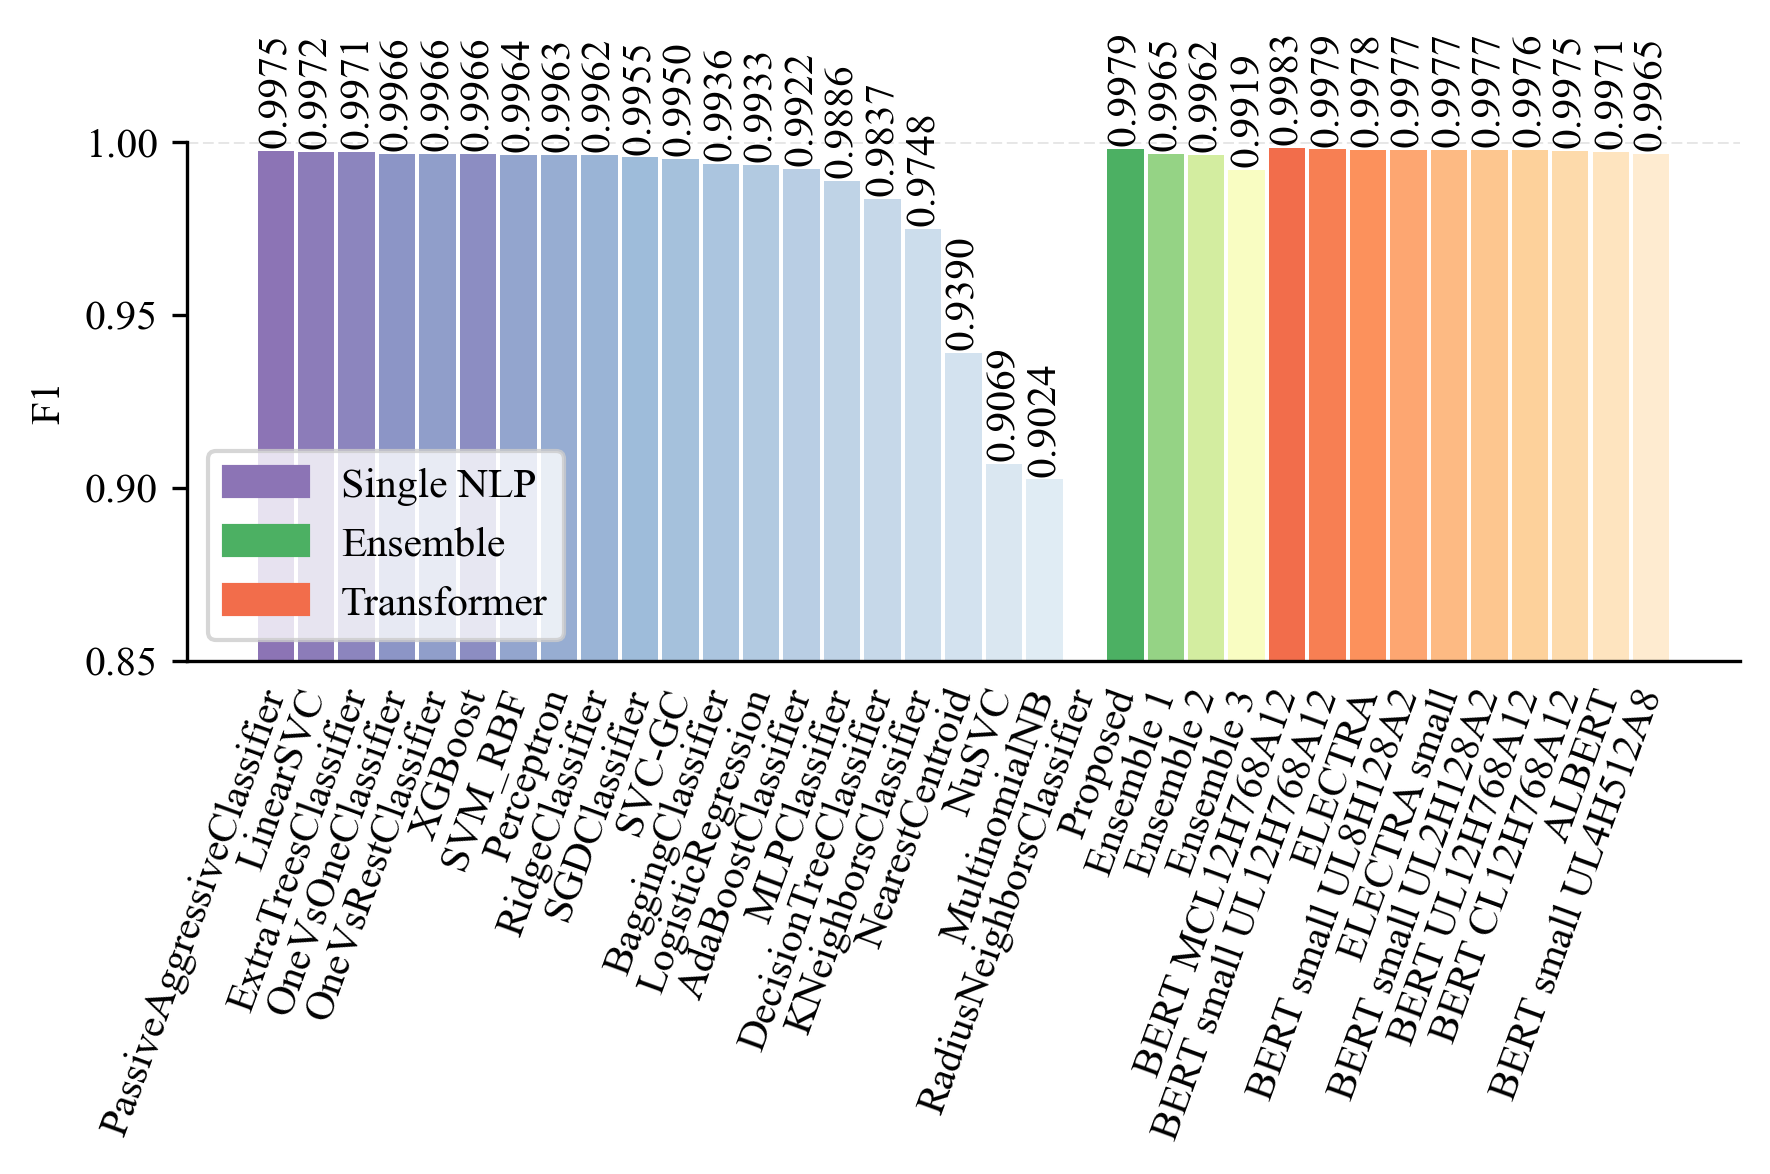

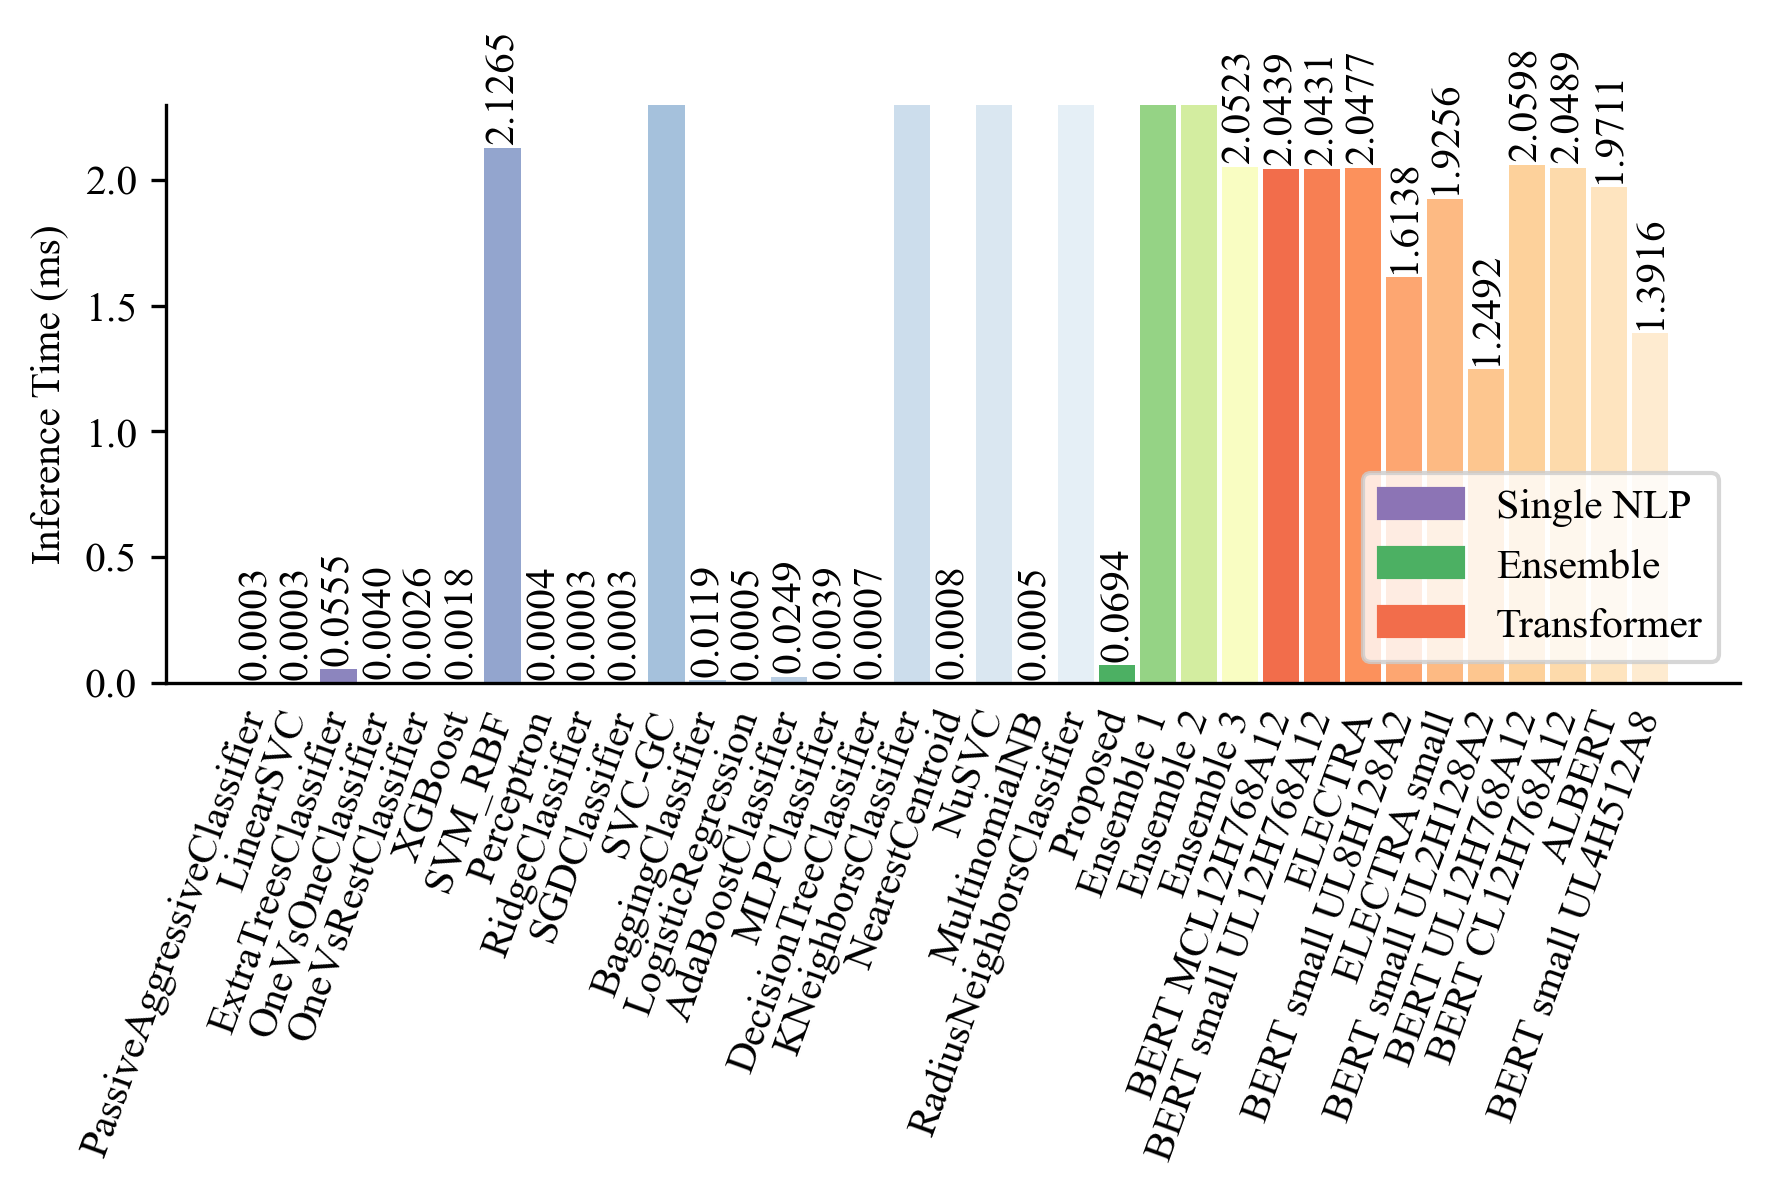

In [24]:
# method_category = 'transformer'
# metrics = ['overall_accuracy', 'precision', 'recall', 'f1', 'training time',
#        'testing time', 'color']
import matplotlib.patches as mpatches
df_small = df.sort_values(['category','f1_score'],ascending=[True, False])
df_small = rename_table_labels(df_small)
#df_small = df.loc[methods[method_category], metrics]
#df_small = df_small.sort_values(['category','f1'],ascending=[True, False])

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_2 = np.asarray(df_small[df_small['category']=='ensemble'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_3 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
legend_cat_1 = mpatches.Patch(color=color_cat_1, label='Single NLP')
legend_cat_2 = mpatches.Patch(color=color_cat_2, label='Ensemble')
legend_cat_3 = mpatches.Patch(color=color_cat_3, label='Transformer')

# Figure
current_figure_name = 'all_f1_sorted_f1.png'
fig, ax = plt.subplots(figsize=(6, 4))
my_plot_bar(df_small,ax,'F1')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.85, 1))
ax.set_ylabel('F1')
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower left')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)
###############################
current_figure_name = 'all_f1_sorted_inference_time.png'
fig, ax = plt.subplots(figsize=(6, 4))
my_plot_bar(df_small,ax,'Inference Time (ms)')
ax.set_ylabel('Inference Time (ms)')
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower right')
ax.set(ylim=(0.0, 2.3))
fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

In [25]:
def process_style_to_my_latex_format(df_latex):
    # returns style object
    s = df_latex.reset_index().style.hide_index()
    s = s.format(precision=4, escape="latex")
    return s

### Single NLP (F1 vs Inference)

In [26]:
# Table: Single NLP
table_name = "single"
caption="Accuracy and inference speed of single NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'classic_ml'
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'train_time',
       'pred_time', 'color', 'category', 'Method']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
df_small.set_index('Method', inplace=True)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))

s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
    s.to_latex(buf=out_file_name,
       column_format="lrrrrrr", position="htbp", position_float="centering",
       hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)
#df.loc[:,"training time"] / df.loc[:,"train size"]
#(df.loc[:,["training time", "testing time"]]*1000).div(df.loc[:,["train size", "test size"]])

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of single NLP methods.}
\label{table:single}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
AdaBoostClassifier & 0.9942 & 0.9962 & 0.9882 & 0.9922 & 0.8238 & 0.0249 \\
BaggingClassifier & 0.9953 & 0.9969 & 0.9904 & 0.9936 & 2.3887 & 0.0119 \\
DecisionTreeClassifier & 0.9880 & 0.9950 & 0.9726 & 0.9837 & 0.0727 & 0.0007 \\
ExtraTreesClassifier & 0.9978 & 0.9995 & 0.9947 & 0.9971 & 0.4283 & 0.0555 \\
KNeighborsClassifier & 0.9815 & 0.9829 & 0.9668 & 0.9748 & 0.0005 & 31.6636 \\
LinearSVC & 0.9979 & 0.9996 & 0.9948 & 0.9972 & 0.0052 & \textbf{0.0003} \\
LogisticRegression & 0.9951 & 0.9986 & 0.9881 & 0.9933 & 0.0684 & 0.0005 \\
MLPClassifier & 0.9917 & 0.9982 & 0.9793 & 0.9886 & 1.8507 & 0.0039 \\
MultinomialNB & 0.9209 & 0.8309 & 0.9876 & 0.9024 & 0.0007 & 0.0005 \\
NearestCentroid & 0.9570 & 0.9882 & 0.8945 & 0.9390 & 0.001

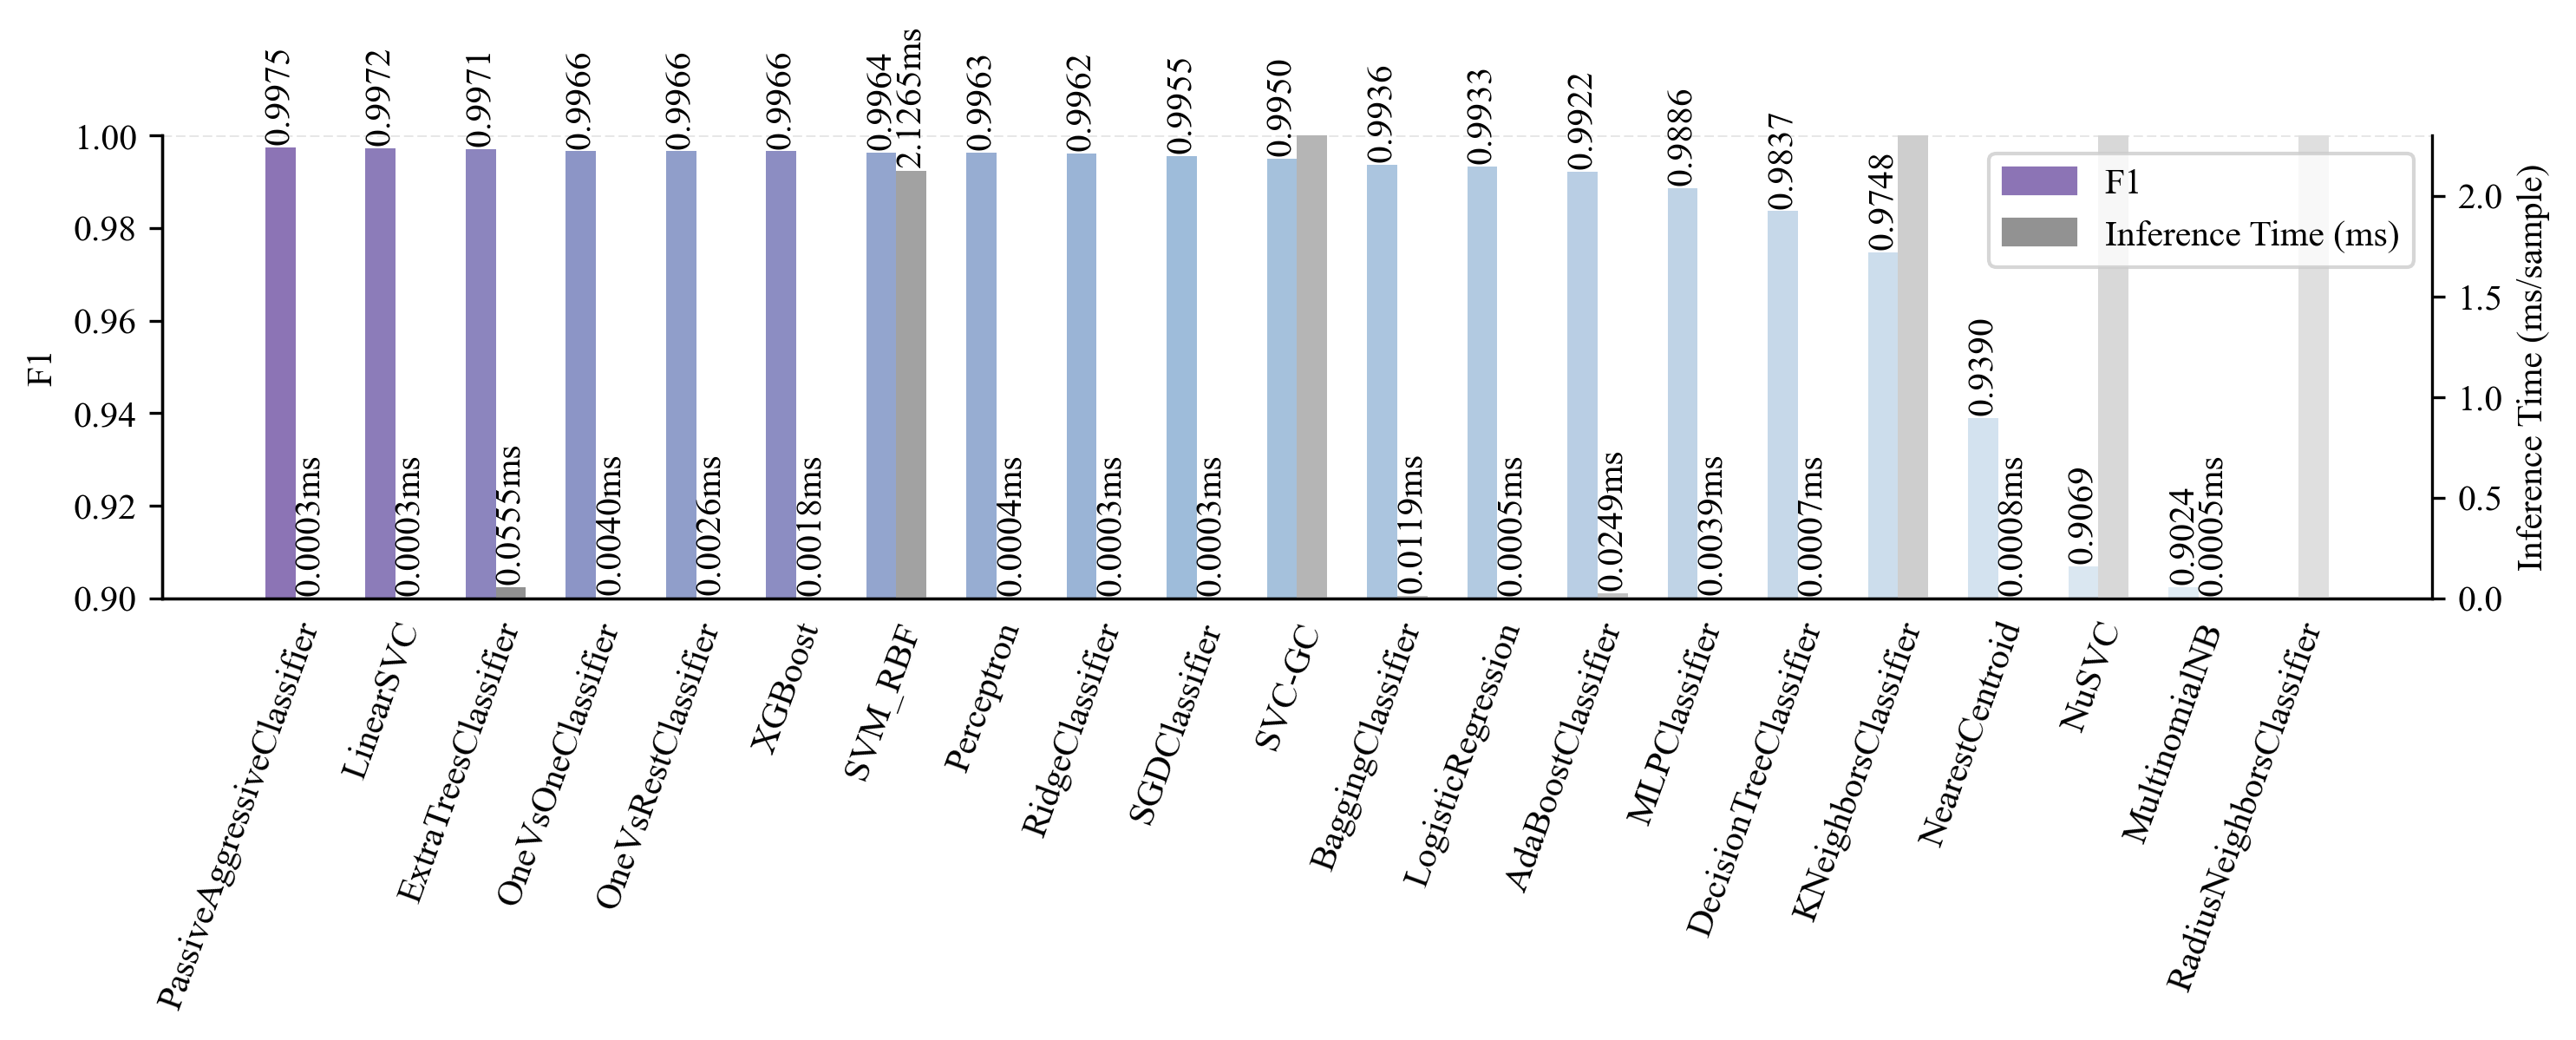

In [27]:
# Figure of Table Single NLP
current_figure_name = 'single_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(10,4))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])


df_small.reset_index(inplace=True)
_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')

ax2.set_ylabel('Inference Time (ms/sample)')
ax2.set(ylim=(0.0, 2.3))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='upper right')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### Table Ensemble NLP

In [28]:
# Table: Ensemble NLP
table_name = "ensemble"
caption="Accuracy and inference speed of ensemble NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'ensemble'
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'train_time',
       'pred_time', 'color', 'category', 'Method']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
df_small.set_index('Method', inplace=True)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))


s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
       s.to_latex(buf=out_file_name,
              column_format="lrrrrrr", position="htbp", position_float="centering",
              hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of ensemble NLP methods.}
\label{table:ensemble}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
Ensemble 1 & 0.9974 & 0.9996 & 0.9934 & 0.9965 & 22.5116 & 3.5582 \\
Ensemble 2 & 0.9972 & 0.9996 & 0.9929 & 0.9962 & 22.5116 & 3.5620 \\
Ensemble 3 & 0.9940 & 0.9942 & 0.9896 & 0.9919 & \textbf{4.9306} & 2.0523 \\
Proposed & \textbf{0.9984} & \textbf{0.9999} & \textbf{0.9959} & \textbf{0.9979} & 48.5331 & \textbf{0.0694} \\
\bottomrule
\end{tabular}
\end{table}



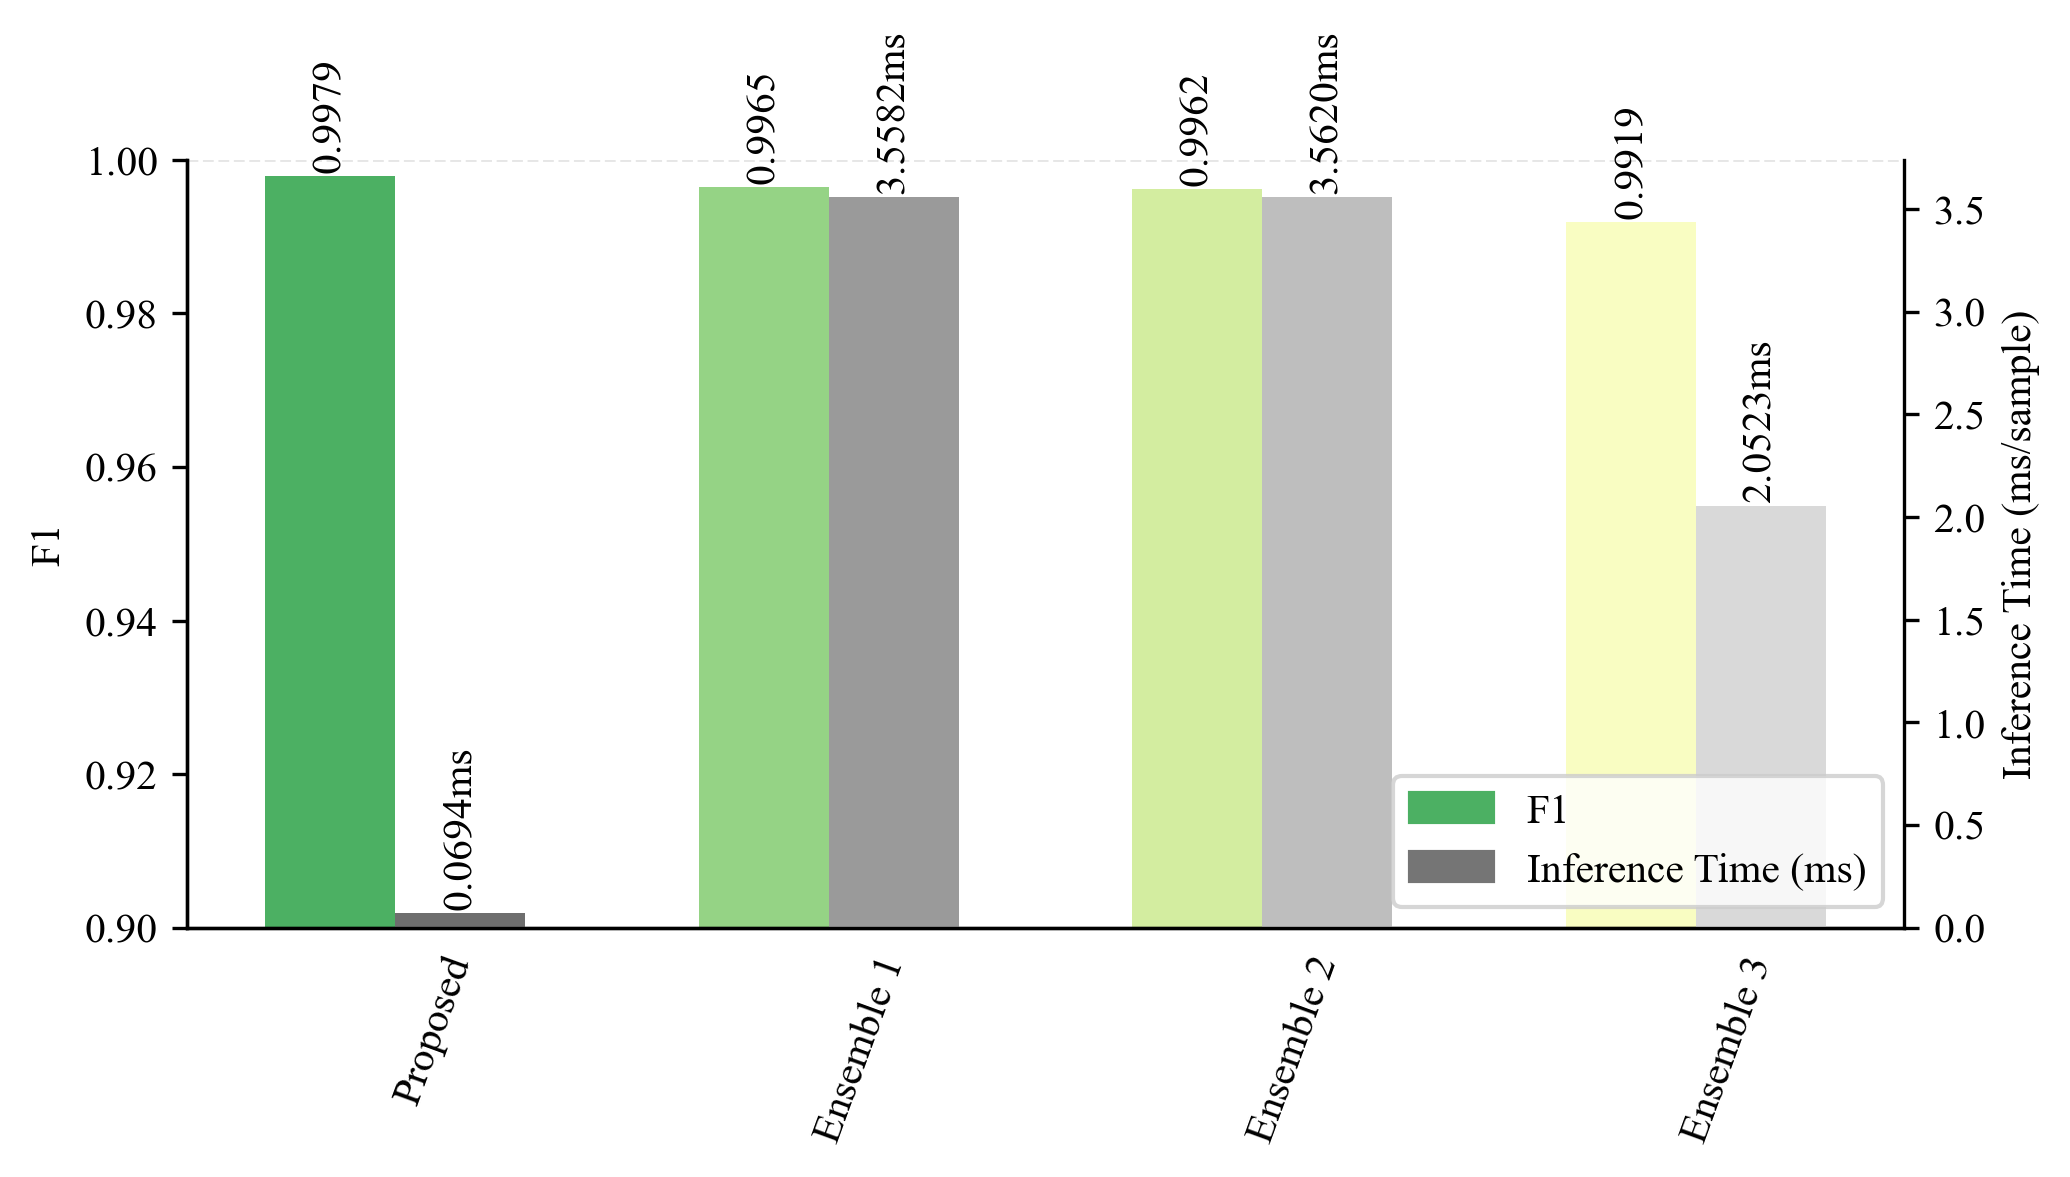

In [29]:
# Figure of Table Ensemble NLP
current_figure_name = 'ensemble_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(7,4))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='ensemble'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])


df_small.reset_index(inplace=True)
_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')

ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='lower right')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### Transformers

In [30]:
# Table: Transformer NLP
table_name = "transformer"
caption="Accuracy and inference speed of trasnformer NLP methods."
out_file_name = (table_folder / table_name).with_suffix('.tex') 
method_cat = 'transformer'
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'train_time',
       'pred_time', 'color', 'category', 'Method']

df_small = df.loc[df['category']==method_cat,metrics]

df_small = rename_table_labels(df_small)
df_small.set_index('Method', inplace=True)
#print(df_small)

s = process_style_to_my_latex_format(df_small.drop(['color', 'category'], axis=1 ))


s = s.highlight_max(props='textbf:--rwrap;', subset=s.columns[1:-2])
s = s.highlight_min(props='textbf:--rwrap;', subset=s.columns[-2:])

if SAVE_OUTPUTS:
       s.to_latex(buf=out_file_name,
              column_format="lrrrrrr", position="htbp", position_float="centering",
              hrules=True, label=f"tab:{table_name}", caption=caption)

print(s.to_latex(
    column_format="lrrrrrr", position="ht", position_float="centering",
    hrules=True, label=f"table:{table_name}", caption=caption)
)

\begin{table}[ht]
\centering
\caption{Accuracy and inference speed of trasnformer NLP methods.}
\label{table:transformer}
\begin{tabular}{lrrrrrr}
\toprule
{Method} & {Accuracy} & {Precision} & {Recall} & {F1} & {Training Time (ms)} & {Inference Time (ms)} \\
\midrule
ALBERT & 0.9978 & 0.9983 & 0.9958 & 0.9971 & 12.3332 & 1.9711 \\
BERT CL12H768A12 & 0.9982 & 0.9979 & 0.9972 & 0.9975 & 12.8636 & 2.0489 \\
BERT UL12H768A12 & 0.9983 & 0.9979 & 0.9974 & 0.9976 & 13.0167 & 2.0598 \\
BERT MCL12H768A12 & \textbf{0.9988} & 0.9993 & 0.9974 & \textbf{0.9983} & 14.5866 & 2.0439 \\
ELECTRA & 0.9984 & 0.9979 & \textbf{0.9978} & 0.9978 & 12.8706 & 2.0477 \\
ELECTRA small & 0.9983 & 0.9986 & 0.9968 & 0.9977 & 10.7674 & 1.9256 \\
BERT small UL12H768A12 & 0.9984 & 0.9983 & 0.9974 & 0.9979 & 12.7917 & 2.0431 \\
BERT small UL2H128A2 & 0.9983 & \textbf{0.9994} & 0.9960 & 0.9977 & \textbf{4.7080} & \textbf{1.2492} \\
BERT small UL4H512A8 & 0.9974 & 0.9960 & 0.9970 & 0.9965 & 6.1357 & 1.3916 \\
BERT small 

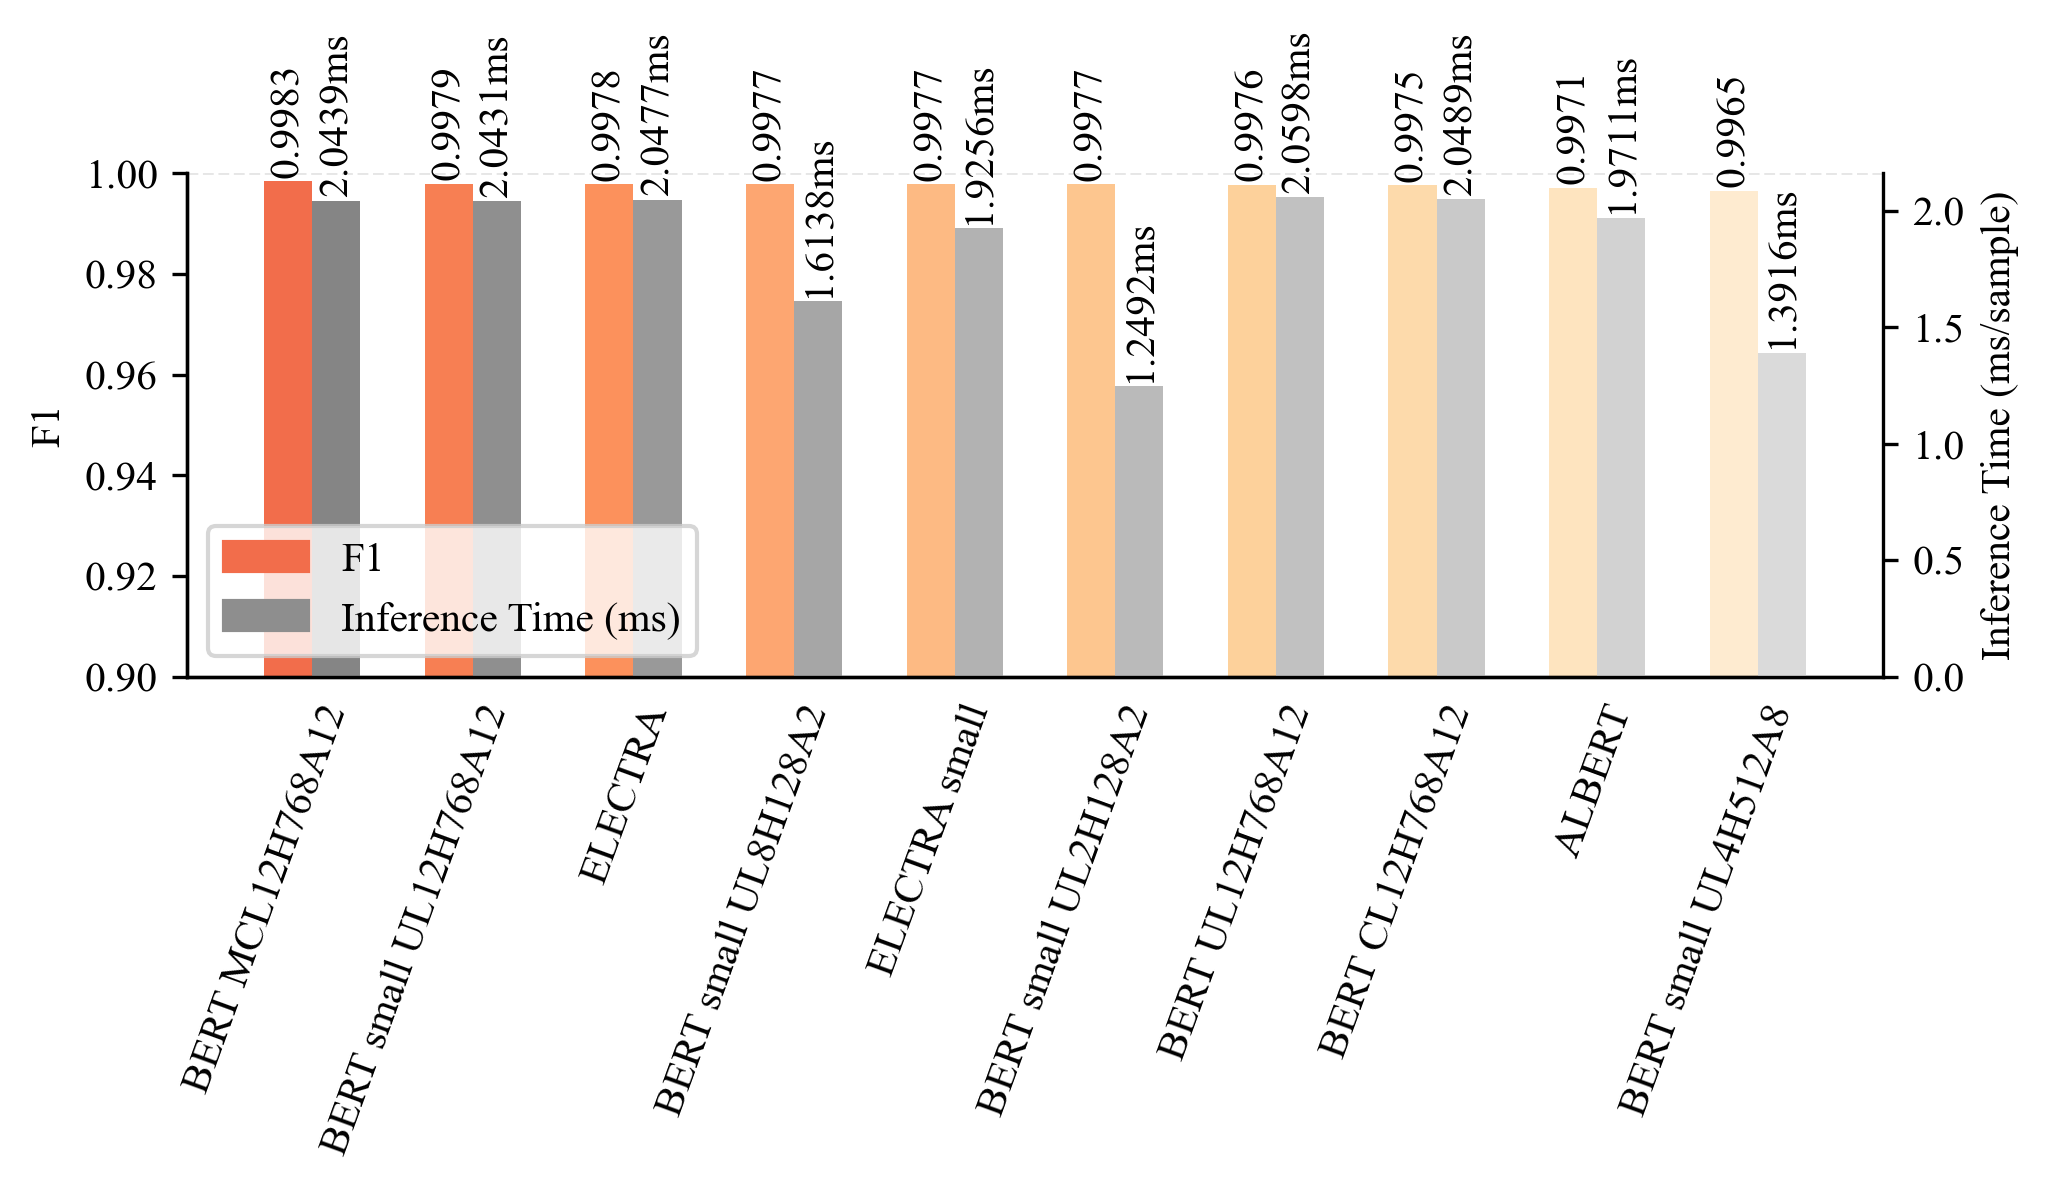

In [31]:
# Figure of Table Transformer NLP
current_figure_name = 'transformer_nlp_f1_vs_time.png'
fig, ax = plt.subplots( figsize=(7,4))

metric = ['F1', 'Inference Time (ms)']
df_small = df_small.sort_values(metric,ascending=False)

# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32)
color_cat_1G = color_cat_1.copy()
color_cat_1G[0:3] = color_cat_1G[0:3].mean()

legend_cat_1 = mpatches.Patch(color=color_cat_1, label=metric[0])
legend_cat_1G = mpatches.Patch(color=color_cat_1G, label=metric[1])


df_small.reset_index(inplace=True)
_, ax2 = my_plot_twin_bar(df_small,ax,metric)
ax.axhline(1,  linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set(ylim=(0.90, 1))
ax.set_ylabel('F1')


ax2.set_ylabel('Inference Time (ms/sample)')
# #ax.set(ylim=(0.95, 1))
ax2.legend(handles=[legend_cat_1, legend_cat_1G],  loc='lower left')
fig.tight_layout()
if SAVE_OUTPUTS:
    ax2.get_figure().savefig(figure_folder / current_figure_name)


### All methods FE score vs alpha

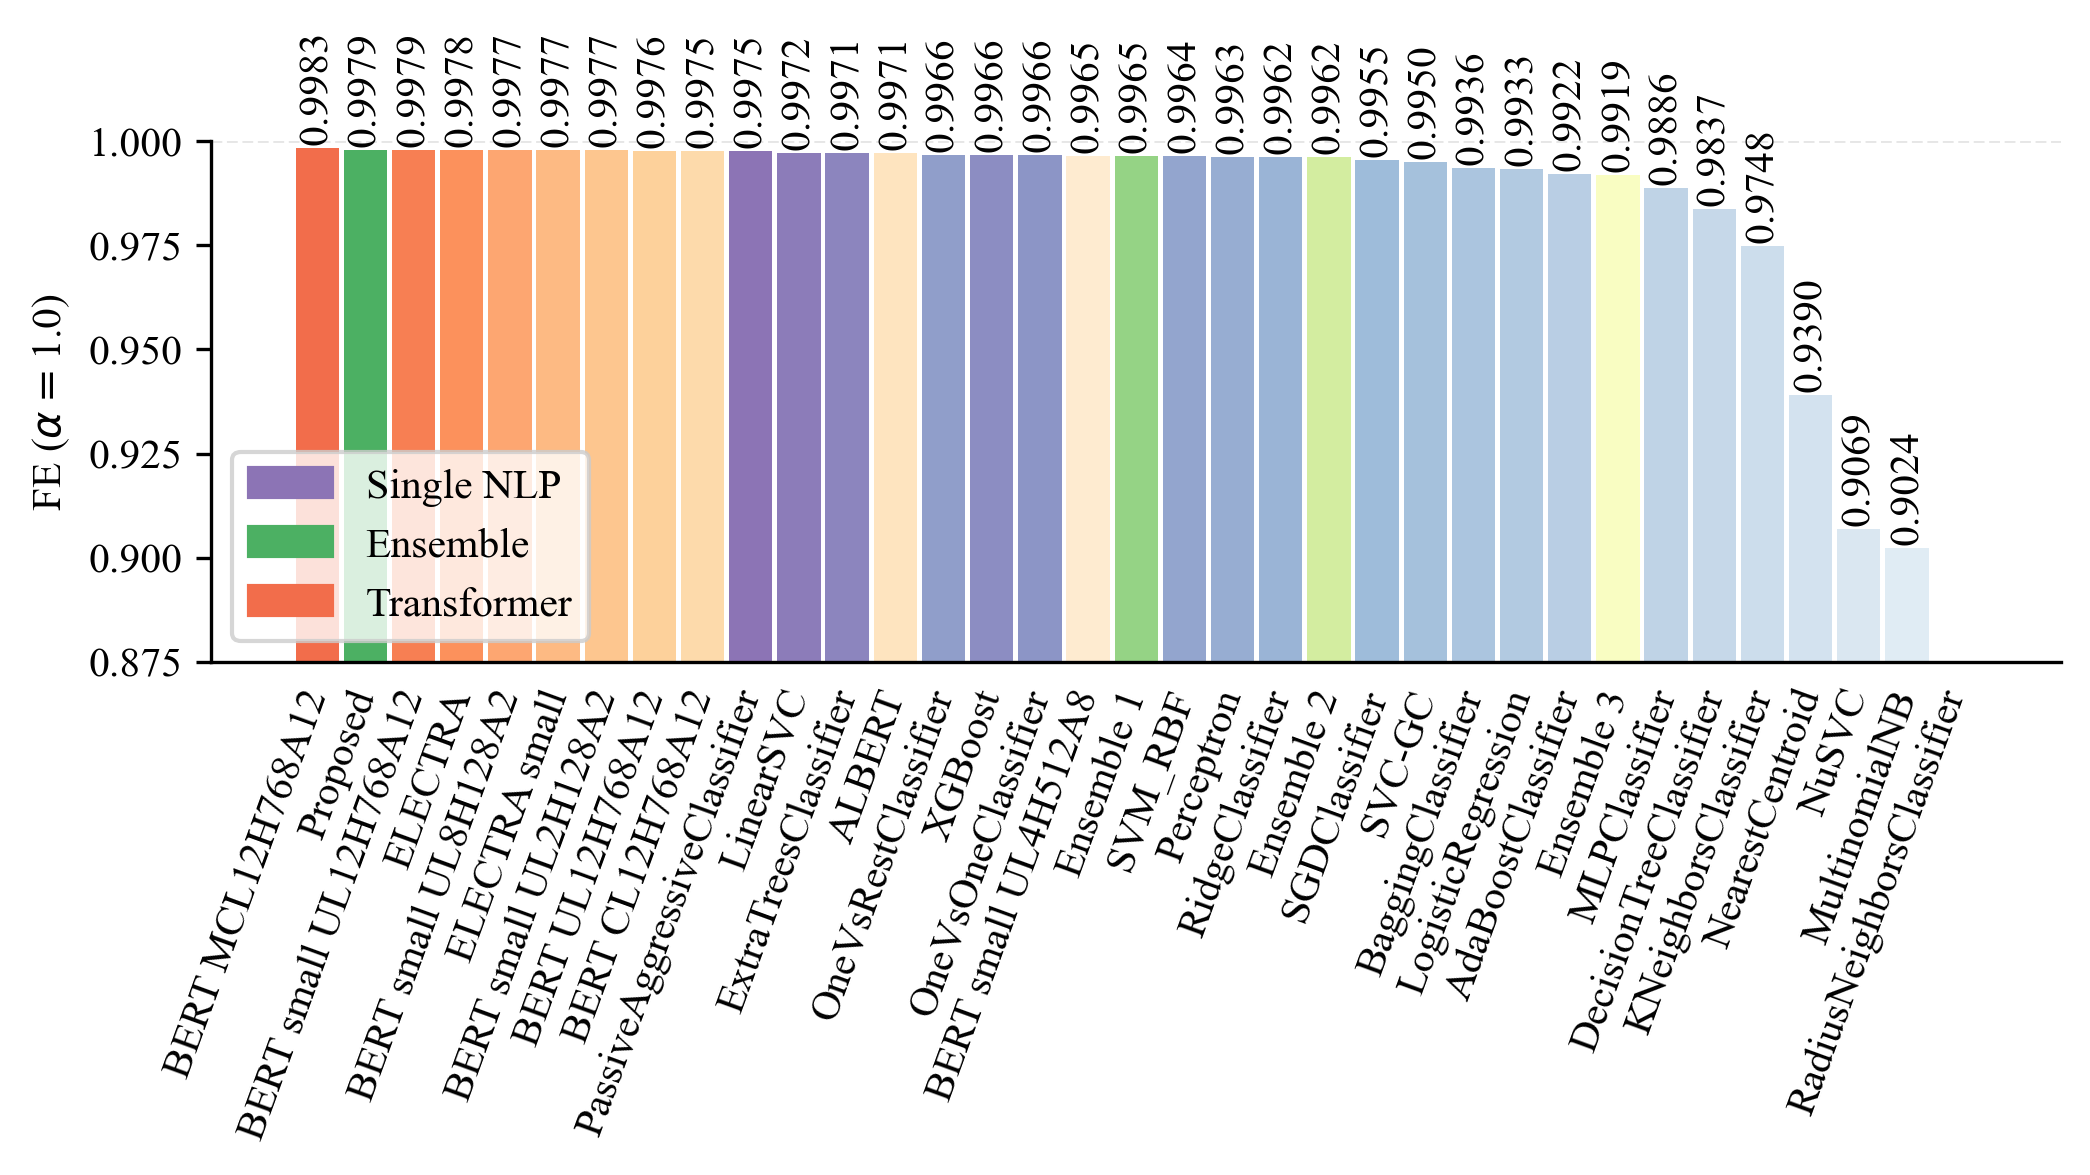

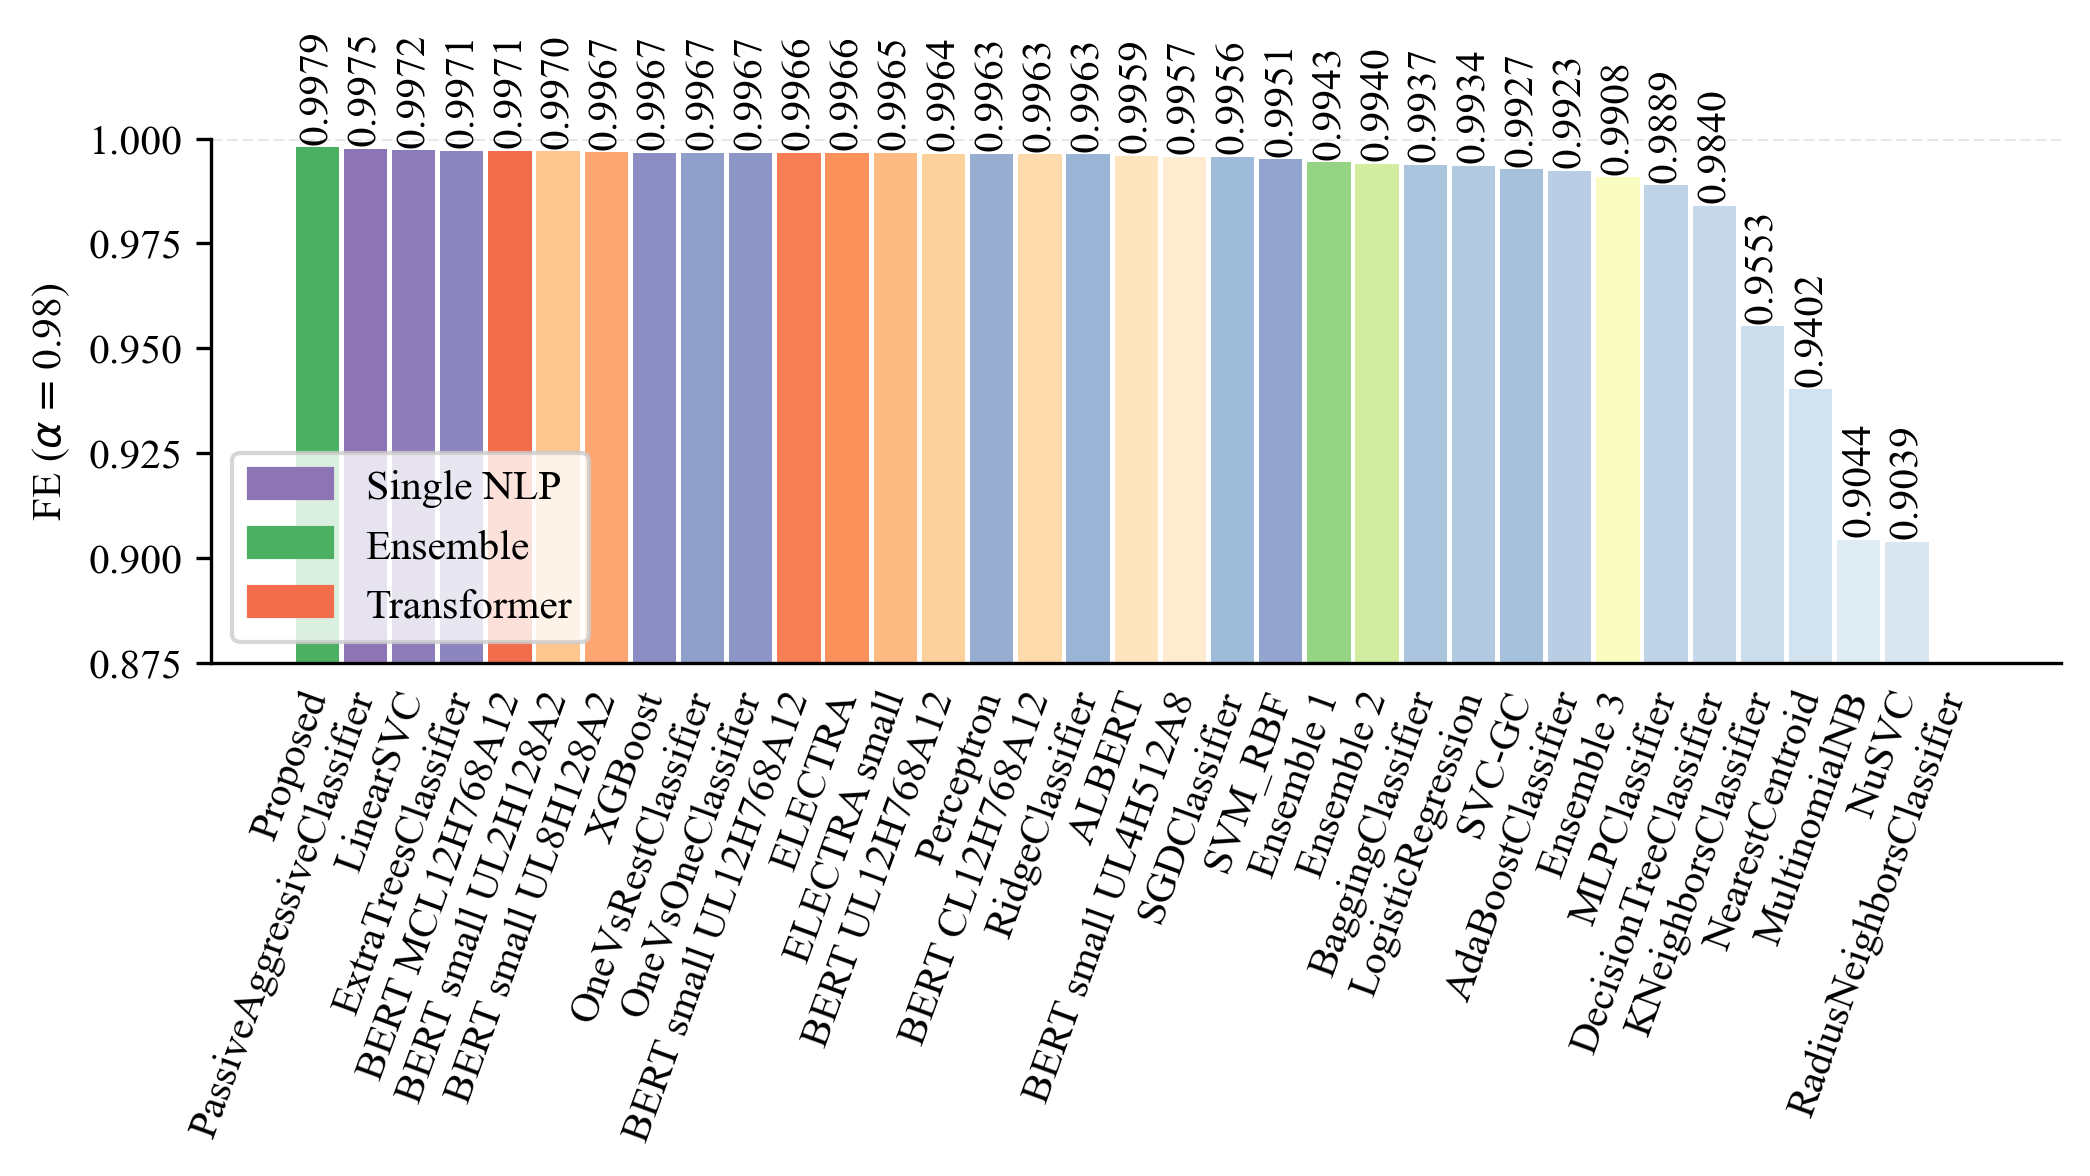

In [32]:
#ALL FE comparison for different alpha
from sklearn import preprocessing

current_figure_name = 'all_nlp_FE_alpha_100.png'

#df_small = df.sort_values(['category','f1'],ascending=[True, False])
df_small = df.sort_values('f1_score',ascending=False)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(1.0000 - df_small['pred_time'].to_numpy().reshape(-1, 1))
df_small['inference scaled'] = x_scaled

alpha = 1.0
#alpha=1.00 #emphasis on F1 rather than speed
df_small['FE_100'] = alpha*df_small['f1_score'] + (1-alpha)*df_small['inference scaled']
#print(df_small)
alpha = 0.98
df_small['FE_098'] = alpha*df_small['f1_score'] + (1-alpha)*df_small['inference scaled']

df_small = rename_table_labels(df_small)



# legend
color_cat_1 = np.asarray(df_small[df_small['category']=='classic_ml'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_2 = np.asarray(df_small[df_small['category']=='ensemble'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
color_cat_3 = np.asarray(df_small[df_small['category']=='transformer'] 
                         .head(1)['color'].values[0][0], dtype=np.float32) 
legend_cat_1 = mpatches.Patch(color=color_cat_1, label='Single NLP')
legend_cat_2 = mpatches.Patch(color=color_cat_2, label='Ensemble')
legend_cat_3 = mpatches.Patch(color=color_cat_3, label='Transformer')

# Figure
fig, ax = plt.subplots(figsize=(7, 4))
df_small = df_small.sort_values('FE_100',ascending=False)

my_plot_bar(df_small,ax,'FE_100')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)

ax.set_ylabel('FE'+ r' ($\alpha=$' + f'{1.0})')
#ax.set_xlabel(r'$\alpha=$' + f'{alpha}')
ax.set(ylim=(0.875, 1))
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower left')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

#########################
current_figure_name = 'all_nlp_FE_alpha_090.png'
fig, ax = plt.subplots(figsize=(7, 4))
df_small = df_small.sort_values('FE_098',ascending=False)
my_plot_bar(df_small,ax,'FE_098')
plt.axhline(1, linestyle='--', linewidth=0.7, color=[0.9,0.9,0.9], zorder=0)
ax.set_ylabel('FE'+ r' ($\alpha=$' + f'{0.98})')
#ax.set_xlabel()
ax.set(ylim=(0.875, 1))
ax.legend(handles=[legend_cat_1, legend_cat_2, legend_cat_3],  loc='lower left')

fig.tight_layout()
if SAVE_OUTPUTS:
    ax.get_figure().savefig(figure_folder / current_figure_name)

# TODO
- 

# End